In [155]:
import numpy as np
import pandas as pd
from music21 import converter, note, chord
import random
from tensorflow.keras import layers, callbacks, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [14]:
def extractNote(element):
    return int(element.pitch.ps)


def extractDuration(element):
    return element.duration.quarterLength


def get_notes(notes_to_parse):
    """
    Get all the notes and chords from the midi files in the ./midi_songs directory
    """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))

        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element.notes:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start": start, "pitch": notes, "dur": durations}



def random_xy(matrix, len_x, len_y):

    '''
    Create random couple X, y of given length out of input matrix
    '''

    width, length = matrix.shape

    start = random.randint(0,width-(len_x+len_y))

    left_x = start
    right_x = start + len_x

    left_y = right_x
    right_y = right_x + len_y

    return matrix[:, left_x:right_x], matrix[:, left_y:right_y]

def midi_to_matrix(midi_path, resolution=1/16, lowerBoundNote=21, upperBoundNote=127):

    '''
    Takes in a midi file and returns a numpy array:
        rows = notes
        columns = time (resolution parameter)
    '''

    mid = converter.parse(midi_path)

    data = {}

    notes_to_parse = mid.flat.notes
    data = get_notes(notes_to_parse)

    pitches = data["pitch"]
    durs = data["dur"]
    starts = data["start"]

    matrix = np.zeros((upperBoundNote - lowerBoundNote,
                       int((max(starts) + durs[-1]) / resolution)))

    for dur, start, pitch in zip(durs, starts, pitches):
        dur = int(dur / resolution)
        start = int(start / resolution)

        for j in range(start, start + dur):
            # added line below to create clear division inbetween notes
            matrix[pitch - lowerBoundNote, start - 1] = 0
            matrix[pitch - lowerBoundNote, j] = 1

    return matrix



def get_X_y(midi_path, resolution, len_x, len_y, n_sequences):
    '''
    Create dataframe out of midi file with random X,y
    '''
    X = []
    y = []
    matrix = midi_to_matrix(midi_path, resolution)
    for n in range(n_sequences):
        split_ = random_xy(matrix, len_x, len_y)
        X += [split_[0].T]
        y += [split_[1].T]
    return np.array(X), np.array(y)

In [9]:
!pwd

/home/lazydragoon/code/lansoni/bach_propagation/bach_propagation/notebooks


In [72]:
X, y = get_X_y('/home/lazydragoon/code/lansoni/bach_propagation/bach_propagation/data/bach_847.mid', .25, 64, 1, 500)

In [73]:
X.shape

(500, 64, 106)

In [74]:
y.shape

(500, 1, 106)

In [76]:
y = y.reshape(500, -1)

In [77]:
y.shape

(500, 106)

In [78]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=.2)

In [79]:
Xtrain.shape

(400, 64, 106)

In [80]:
yval.shape

(100, 106)

In [39]:
from sys import getsizeof

getsizeof(X)

27136136

In [259]:
def init_model(number_of_samples, input_length, heights):
    model = models.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(input_length, heights)))
    model.add(layers.LSTM(100))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(heights, activation='sigmoid'))
    return model

def compile_model(model):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def next_note(predict_note, threshold): #we may want to make 'costum' predictions: if heights have probs>threshold, play them all
    return (predict_note > threshold).astype('int')


metrics: negative log likelihood

## improving with custom loss 

In [255]:
model = init_model(500, 64, 106)

In [256]:
compile_model(model)

In [257]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 15)            1605      
                                                                 
 lstm_26 (LSTM)              (None, 64, 100)           46400     
                                                                 
 lstm_27 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 106)               10706     
                                                                 
Total params: 139,111
Trainable params: 139,111
Non-trainable params: 0
_________________________________________________________________


In [258]:
es = callbacks.EarlyStopping(patience=25, restore_best_weights=True)

model.fit(Xtrain, ytrain, epochs=100, callbacks=es, validation_data=(Xval, yval))

Epoch 1/100


ValueError: in user code:

    File "/home/lazydragoon/.pyenv/versions/3.8.12/envs/bach_propagation/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/lazydragoon/.pyenv/versions/3.8.12/envs/bach_propagation/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/lazydragoon/.pyenv/versions/3.8.12/envs/bach_propagation/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/lazydragoon/.pyenv/versions/3.8.12/envs/bach_propagation/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/home/lazydragoon/.pyenv/versions/3.8.12/envs/bach_propagation/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/lazydragoon/.pyenv/versions/3.8.12/envs/bach_propagation/lib/python3.8/site-packages/keras/engine/input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_16" (type Sequential).
    
    Input 0 of layer "lstm_26" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 64, 106, 15)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 64, 106), dtype=float32)
      • training=True
      • mask=None


In [120]:
model.predict(Xval[0:1]).shape

(1, 106)

In [118]:
np.expand_dims(Xval[0],0).shape

(1, 64, 106)

In [125]:
(Xval[0]).shape

(64, 106)

In [235]:
def predict_next_measure(resolution, Xtest, fitted_model): 
    heights =  Xtest.shape[1]
    steps = int(4 * 1/resolution) #resolution is the number steps per 'time', and we want a 
    Z = Xtest
    
    ans = np.zeros(heights)
    for _ in range(steps):
        
        Z = np.expand_dims(Z, axis=0) #Xtest is a 2D array but we want 3D to comply with the model 
        y_pred = fitted_model.predict(Z)    
        Z = Z.reshape(-1, heights)
        
        Z = np.vstack((Z[1:-1,:], y_pred))
        
        
        ans = np.vstack((ans, y_pred))
        
    return ans

In [236]:
ymeas = predict_next_measure(.05, Xval[0], model)

In [237]:
ymeas

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04957882, 0.10583892, 0.05265433, ..., 0.19607866, 0.03979158,
        0.04046386],
       [0.04958206, 0.10583898, 0.05263203, ..., 0.19603717, 0.03977844,
        0.04044801],
       ...,
       [0.44893882, 0.46999538, 0.45243591, ..., 0.47050336, 0.45229143,
        0.44923636],
       [0.44893882, 0.46999538, 0.45243591, ..., 0.47050336, 0.45229143,
        0.44923636],
       [0.44893882, 0.46999538, 0.45243591, ..., 0.47050336, 0.45229143,
        0.44923636]])

In [238]:
Xval[0].sum()

114.0

In [239]:
ymeas.shape

(81, 106)

In [240]:
ymeas.T

array([[0.        , 0.04957882, 0.04958206, ..., 0.44893882, 0.44893882,
        0.44893882],
       [0.        , 0.10583892, 0.10583898, ..., 0.46999538, 0.46999538,
        0.46999538],
       [0.        , 0.05265433, 0.05263203, ..., 0.45243591, 0.45243591,
        0.45243591],
       ...,
       [0.        , 0.19607866, 0.19603717, ..., 0.47050336, 0.47050336,
        0.47050336],
       [0.        , 0.03979158, 0.03977844, ..., 0.45229143, 0.45229143,
        0.45229143],
       [0.        , 0.04046386, 0.04044801, ..., 0.44923636, 0.44923636,
        0.44923636]])

In [241]:
A  = (ymeas.T > .1).astype('int')

In [231]:
A

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [232]:
A.sum()

38341

In [160]:
A.sum()

256

In [161]:
A.shape

(106, 17)

In [182]:
B = np.sum(A, axis=0)

In [183]:
B

array([ 0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16])

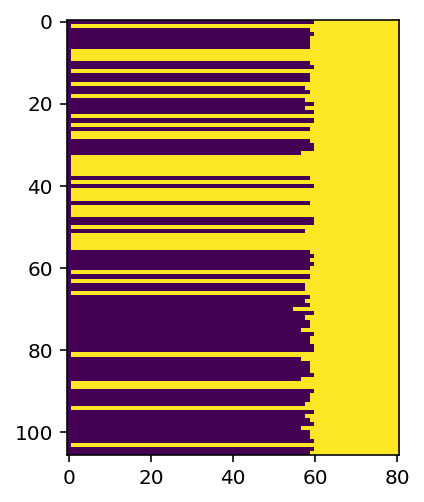

In [242]:
plt.imshow(A)

In [151]:
from bach_propagation.utils import matrix_to_midi, matrix_to_image, image2midi

In [148]:
matrix_to_midi(A, '1st_try', .25) 

In [150]:
matrix_to_image(A, '1st_img')

In [153]:
image2midi('1st_img.png', .25)